In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import StationaryGaussianProcess

from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as np
import yaml
from led_array.tf_util import prepare_test_dataset
import tensorflow.keras as tfk


bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-12-01 13:09:30.561443: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Opening BSCCM
Opened BSCCM


In [4]:
experiment_dir = '/home/hpinkard_waller/models/Synthetic_Noise_v6/'

mi_estimates_gp = {}
mi_estimates_pixel_cnn = {}
phenotype_nlls = {}
phenotype_marker_indices = {}
for dir_name in os.listdir(experiment_dir):
    if 'Analysis' in dir_name:
        config_file_name = [d for d in os.listdir(os.path.join(experiment_dir, dir_name)) if '.yaml' in d][0]
        config_file_full_path = os.path.join(experiment_dir, dir_name, config_file_name)
        config = yaml.load(open(config_file_full_path, 'r'), Loader=yaml.FullLoader)
        photons_per_pixel = config['data']['synthetic_noise']['photons_per_pixel']
        channel = config['data']['channels'][0]
        replicate = config['metadata']['replicate']
        saving_dir = os.path.join(experiment_dir, dir_name)
        analysis_dir = os.path.join(saving_dir, 'analysis')
        mi_estimate_file = np.load(os.path.join(analysis_dir, [f for f in os.listdir(analysis_dir) if 'mi_estimates' in f][0]))
        mi_estimates_gp[(channel, photons_per_pixel, replicate)] = mi_estimate_file['mi_gp']


        mi_estimates_pixel_cnn[(channel, photons_per_pixel, replicate)] = mi_estimate_file['mi_pixel_cnn']
        nll_file = np.load(os.path.join(analysis_dir, [f for f in os.listdir(analysis_dir) if 'phenotyping_nll' in f][0]))
        phenotype_nlls[(channel, photons_per_pixel, replicate)] = nll_file['nlls']
        phenotype_marker_indices[(channel, photons_per_pixel, replicate)] = nll_file['marker_indices']

        # print the channel, photons and mi_gp
        print(channel, photons_per_pixel, mi_estimates_pixel_cnn[(channel, photons_per_pixel, replicate)])    

Analysis_Synthetic_Noise_v6_LED119_200photons_replicate_0
LED119 200 0.40115761084107765
Analysis_Synthetic_Noise_v6_LED119_50photons_replicate_0
LED119 50 0.2216610177236674
Analysis_Synthetic_Noise_v6_Brightfield_200photons_replicate_0
Brightfield 200 0.0376172087944094
Analysis_Synthetic_Noise_v6_LED119_100photons_replicate_0
LED119 100 0.3012602552989415
Analysis_Synthetic_Noise_v6_DPC_Right_50photons_replicate_0
DPC_Right 50 0.09652959274172766
Analysis_Synthetic_Noise_v6_DPC_Right_100photons_replicate_0
DPC_Right 100 0.1316977310058628
Analysis_Synthetic_Noise_v6_Brightfield_100photons_replicate_0
Brightfield 100 0.03693472114682598


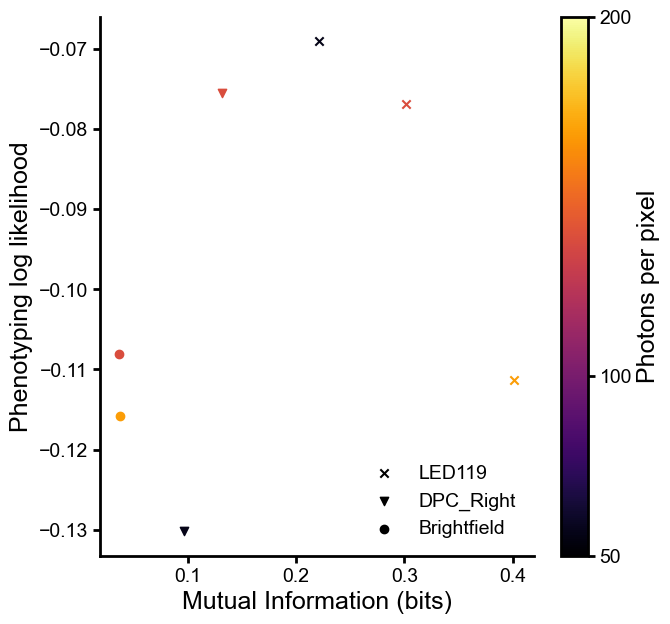

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# iterate through all the tuples and make a scatter plot
for channel, photons_per_pixel, replicate in mi_estimates_gp.keys():
    mi_gp = mi_estimates_gp[(channel, photons_per_pixel, replicate)]
    mi_pixel_cnn = mi_estimates_pixel_cnn[(channel, photons_per_pixel, replicate)]
    nlls = phenotype_nlls[(channel, photons_per_pixel, replicate)]
    marker_indices = phenotype_marker_indices[(channel, photons_per_pixel, replicate)]

    if channel == 'LED119':
        marker = 'x'
    elif channel == 'DPC_Right':
        marker = 'v'
    elif channel == 'Brightfield':
        marker = 'o'

    # get inferno colormap from 0 to 1
    cmap = plt.get_cmap('inferno')


    if photons_per_pixel == 50:
        color = cmap(10)
    elif photons_per_pixel == 100:
        color = cmap(150)
    elif photons_per_pixel == 200:
        color = cmap(200)
    ax.scatter(mi_pixel_cnn, -nlls.mean(), color=color, marker=marker)

ax.set_xlabel('Mutual Information (bits)')
ax.set_ylabel('Phenotyping log likelihood')
clear_spines(ax)
# legend
ax.scatter([], [], color='k', marker='x', label='LED119')
ax.scatter([], [], color='k', marker='v', label='DPC_Right')
ax.scatter([], [], color='k', marker='o', label='Brightfield')
ax.legend(loc='lower right', frameon=False)

# colorbar
cmap = plt.get_cmap('inferno')
norm = mpl.colors.Normalize(vmin=50, vmax=200)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=[50, 100, 200])
cbar.set_label('Photons per pixel')

In [3]:
markers, _, _, _, _ = get_targets_and_display_range(bsccm=bsccm, use_two_spectrum_unmixing=True)
markers

['CD45', 'CD123', 'CD19', 'CD56', 'CD14', 'CD16', 'HLA-DR', 'CD3']